# Inverse design of an apodized grating coupler through shape optimization

A grating coupler (GC) is a key photonic device used to couple light between optical fibers and on-chip waveguides by diffracting light at a specific angle. These devices often employ apodization, a technique that modifies the grating tooth parameters along the device length to improve efficiency and minimize reflection losses. 

In this notebook, we will use gradient-based optimization to determine the optimal grating tooth distribution. We start from a uniform grating coupler and modify the tooth and gap sizes simultaneously using gradient based optimization. Feature size constraints on the parameters enable the device to remain fabricable over the course of optimization. In just a handful of iterations, we achieve a design that outperforms an apodized grating coupler designed using semi-analytical methods.

<img src="img/apodized_grating_feature_image_autograd.png" width=400 alt="Schematic of the coupler">

While the simulations are performed using a 2D cross section, the same approach can be modified to 3D without much further complication.

If you are interested in other inverse design examples using tidy3d, you can find many of them [here](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/docs/features/autograd.html).

If you are unfamiliar with inverse design, we also recommend our [intro to inverse design tutorials](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/) and our [primer on automatic differentiation with tidy3d](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin1Intro/).


In [1]:
# as we are using autograd to perform gradient calculations, we need to import numpy from autograd's wrapper
import autograd as ag
import autograd.numpy as np
import matplotlib.pyplot as plt

# we will use optax to perform the optimization using gradient descent
import optax
import tidy3d as td
import tidy3d.web as web

### Basic Parameters

First, we define the basic parameters used to define a uniform grating coupler for operation primarily in the C-band.

In [2]:
lda0 = 1.55  # central wavelength
n_ldas = 101  # number of wavelength points
ldas = np.linspace(1.5, 1.6, n_ldas)  # wavelength range

freq0 = td.C_0 / lda0  # central frequency
freqs = td.C_0 / ldas  # frequency range

num_freqs_objective = 5
ldas_objective = np.linspace(1.5, 1.6, num_freqs_objective)
freqs_objective = td.C_0 / ldas_objective

fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

The material platform is the common silicon on insulator (SOI) with a 260 nm silicon thickness and 2 µm BOX thickness. The top cladding layer is 680 nm oxide. The grating will be partially etched with an etching depth of 160 nm. 

In [3]:
# define materials from the material library
si = td.material_library["cSi"]["Palik_Lossless"]
sio2 = td.material_library["SiO2"]["Palik_Lossless"]

t_si = 0.26  # thickness of the silicon layer
etch_depth = 0.16  # etching depth
t_tox = 0.68  # top oxide layer thickness
t_box = 2  # bottom oxide layer thickness

We aim to design the GC for the standard single-mode fiber (SMF) with a mode field diameter (MFD) of 10.8 µm. The fiber is tilted at a 14.5 degree angle.

In [4]:
theta = np.deg2rad(14.5)  # fiber tilt angle
mfd = 10.8  # mode field diameter
source_x = 4.5  # x position of the fiber

N = 16  # number of grating teeth to create
inf_eff = 1e3  # effective infinity
buffer = 1.1 * lda0  # buffer spacing to pad the simulation domain

Next we compute the uniform tooth parameters (periodicity and fill fraction) to maximize efficiency.

In [5]:
neff_unetch = 2.9  # effective index of the slab mode of the unetched waveguide
neff_etch = 2.2  # effective index of the slab mode of the etched waveguide
n_c = 1.44  # refractive index of the cladding (SiO2)
theta_c = np.sin(theta) / n_c  # incident angle in the cladding


def get_periodicity(fill_fraction: float) -> float:
    """periodicity (bragg condition) as function of fill fraction, angle, wavelength, and etching parameters."""
    return lda0 / (
        fill_fraction * neff_unetch + (1 - fill_fraction) * neff_etch - n_c * np.sin(theta_c)
    )


f0 = 0.80
periodicity = get_periodicity(f0)
p_list = N * [periodicity]
f_list = N * [f0]

After obtaining $p_{\text{i}}$ and $f_{\text{i}}$, we will write a function to return the width of each air gap and each tooth. We will use these gap widths as the parameters for our design. The advantage is that we can impose bounds on these values to ensure the minimal feature size is above the fabrication constraint. 

Here we aim to have a minimal feature size above 60 nm. The current design has a minimal feature size right above it.

In [6]:
def get_widths(p_list, f_list):
    # calculate the widths of air gaps and silicon teeth
    return np.array([item for p, f in zip(p_list, f_list) for item in [p * (1 - f), p * f]])


widths = get_widths(p_list, f_list)

l_grating = np.sum(widths) + 3 * lda0  # total length of the GC

# print the current minimal feature size
print(f"The minimal feature size is {1e3 * np.min(widths):.2f} nm.")

The minimal feature size is 123.46 nm.


To ensure the minimal feature size is maintained during the optimization, we will use a design parameter in the range from `-inf` to `inf` and project it to a `tanh` function that is bounded by the minimal and maximal feature sizes.

In [7]:
min_width = 0.08  # minimal feature size we want to maintain
max_width = 1  # maximal feature size


# function to project a design parameter between -inf to inf to between min_width and max_width
def project(x):
    return 0.5 * (max_width - min_width) * np.tanh(x) + 0.5 * (max_width + min_width)


# function to inversely project a design parameter between min_width and max_width to between -inf to inf
def inverse_project(y):
    return np.arctanh((2 * (y - 0.5 * (max_width + min_width))) / (max_width - min_width))


# project the widths to parameters between -inf to inf
params0 = inverse_project(widths)

### Define Static Components of the Simulation

Next we will define the components that don't change during the optimization. These include the cladding layer, the output waveguide, the unetched layer, the bottom oxide layer, and the silicon substrate.

In [8]:
mask = td.Structure(
    geometry=td.Box(size=(td.inf, td.inf, td.inf), center=(0, 0, 0)),
    medium=td.Medium(),
)

# create the top oxide layer
tox = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, 0), rmax=(inf_eff, inf_eff, t_tox)),
    medium=sio2,
)

# create the output waveguide
slab_waveguide = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, 0), rmax=(0, inf_eff, t_si)),
    medium=si,
)

# create the unetched waveguide
unetched_waveguide = td.Structure(
    geometry=td.Box.from_bounds(rmin=(0, -inf_eff, 0), rmax=(inf_eff, inf_eff, t_si - etch_depth)),
    medium=si,
)

# create the bottom oxide layer
box = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -t_box), rmax=(inf_eff, inf_eff, 0)),
    medium=sio2,
)

# create the silicon substrate layer
substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, -t_box)
    ),
    medium=si,
)

The source and monitor are not changed either. We use a [GaussianBeam](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.GaussianBeam.html#tidy3d.GaussianBeam) to represent the incident fiber mode. A [ModeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html#tidy3d.ModeMonitor) is placed at the output waveguide to measure the coupling efficiency.

In [9]:
gap = 1  # gap size between the source plane and the top surface of the cladding

# define a gaussian beam source
source = td.GaussianBeam(
    size=(2 * mfd, td.inf, 0),
    center=[source_x, 0, t_tox + gap],
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    angle_theta=theta,
    direction="-",
    waist_radius=mfd / 2,
    pol_angle=np.pi / 2,  # 90 degree polarization angle for TE polarization
)

# define a mode monitor
mode_monitor = td.ModeMonitor(
    center=(-buffer / 2, 0, t_si / 2),
    size=(0, td.inf, 6 * t_si),
    freqs=freqs,
    mode_spec=td.ModeSpec(num_modes=1, target_neff=3),
    name="mode",
)

### Simulate the Designed Apodized GC

To simulate the designed GC and facility future optimization, we define a function that takes in an array of design parameters and returns a [Simulation]() object. Note again that each design parameter has a range from `-inf` to `inf`. It will then be projected to a range between `min_width` and `max_width`.

In [10]:
def make_2d_sim(design_parameters):
    # calculate the widths of air gaps and silicon teeth
    widths_si = project(design_parameters[1::2])
    widths_air = project(design_parameters[::2])

    # initialize the center and size of each silicon teeth
    center = 0
    size = 0

    # create the grating geometries from the given widths
    gratings = 0
    for width_si, width_air in zip(widths_si, widths_air):
        center += width_air + width_si / 2
        size = width_si
        gratings += td.Box(
            center=(center, 0, t_si - etch_depth / 2), size=(size, td.inf, etch_depth)
        )
        center += width_si / 2

    # create the grating structure
    gratings = td.Structure(geometry=gratings, medium=si)

    # create a box to represent the simulation domain box
    sim_box = td.Box.from_bounds(
        rmin=(-buffer, 0, -t_box - buffer / 2),
        rmax=(l_grating + buffer, 0, t_si + buffer),
    )

    run_time = 1e-12  # simulation run time

    # construct simulation
    sim = td.Simulation(
        center=sim_box.center,
        size=sim_box.size,
        grid_spec=td.GridSpec.auto(
            min_steps_per_wvl=30, wavelength=lda0
        ),  # use a fine grid to ensure the small features are well resolved
        structures=[
            mask,
            tox,
            gratings,
            unetched_waveguide,
            slab_waveguide,
            box,
            substrate,
        ],
        sources=[source],
        monitors=[mode_monitor],
        medium=sio2,
        run_time=run_time,
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.pml(),
            y=td.Boundary.periodic(),  # set the boundary to periodic in y since it's a 2D simulation
            z=td.Boundary.pml(),
        ),
    )

    return sim

Create the simulation for the designed apodized GC and visualize it. 

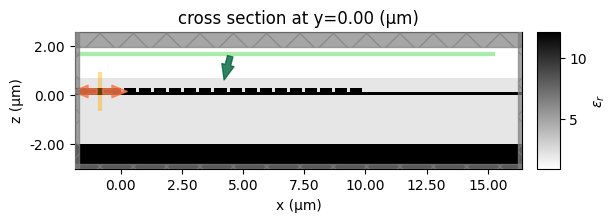

In [11]:
sim0 = make_2d_sim(params0)
sim0.plot_eps(y=0, freq=freq0)
plt.show()

Also visualize the grid to ensure it resolves the small features well.

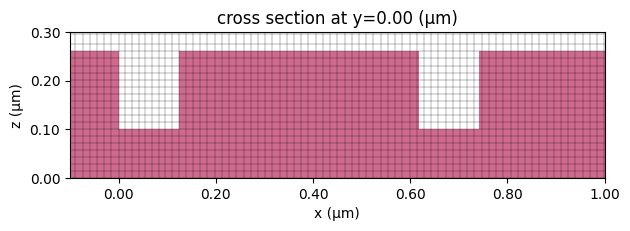

In [12]:
ax = sim0.plot(y=0)
sim0.plot_grid(y=0, ax=ax)
ax.set_xlim(-0.1, 1)
ax.set_ylim(0, 0.3)
plt.show()

Run the simulation.

In [13]:
sim_data0 = web.run(simulation=sim0, task_name="initial design")

13:07:56 CEST Created task 'initial design' with task_id                        
              'fdve-8becd889-1305-4968-9486-4c0a4e5b30ae' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=25649;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8becd889-1305-4968-9486-4c0a4e5b30ae\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=473688;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8becd889-1305-4968-9486-4c0a4e5b30ae\taskId]8;;\]8;id=25649;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8becd889-1305-4968-9486-4c0a4e5b30ae\=]8;;\]8;id=540256;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8becd889-1305-4968-9486-4c0a4e5b30ae\fdve]8;;\]8;id=25649;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8becd889-1305-4968-9486-4c0a4e5b30ae\-8becd889-13]8;;\
              ]8;id=25649;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8becd889-1305-4968-9486-4c0a4e5b30ae\05-4968-9486-4c0a4e5b30ae']8;;\.

              Task folder: ]8;id=623866;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:07:58 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:07:59 CEST status = success

Output()

13:08:01 CEST loading simulation from simulation_data.hdf5

### Result Visualization

After the simulation is done, we can extract the coupling efficiency from the mode monitor data. In addition, we also calculate two important metrics: the maximum coupling efficiency and the 1dB bandwidth. The maximal coupling efficiency is about 2.7dB and the 1dB bandwidth is about 36 nm.

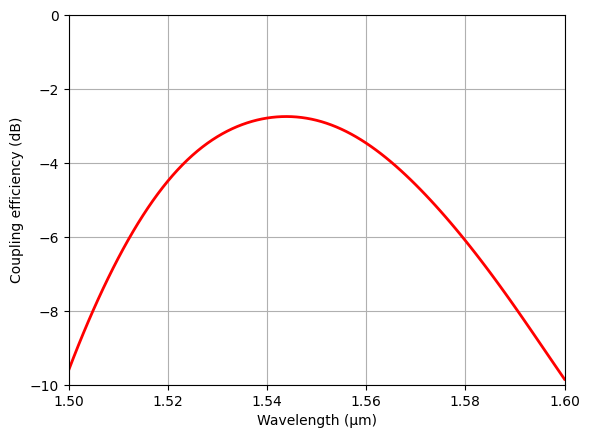

The 1dB bandwidth is 36.0 nm
The maximum coupling efficiency is -2.74 dB.


In [14]:
# function to calculate the coupling efficiency from simulation data
def compute_ce(sim_data):
    amp = sim_data["mode"].amps.sel(mode_index=0, direction="-").values
    ce = np.abs(amp) ** 2  # transmission to the top waveguide
    return ce


def dB(ce):
    return 10 * np.log10(ce)


# calculate the coupling efficiency for the designed GC
ce0 = compute_ce(sim_data0)

# plot the coupling efficiency
plt.plot(ldas, dB(ce0), c="red", linewidth=2)
plt.xlim(min(ldas), max(ldas))
plt.ylim(-10, 0)
plt.xlabel("Wavelength (µm)")
plt.ylabel("Coupling efficiency (dB)")
plt.grid()
plt.show()


# function to calculate the 1dB bandwidth from the coupling efficiency
def bandwidth(ldas, ce):
    max_ce = np.max(dB(ce))

    threshold = max_ce - 1

    within_1db = np.where(dB(ce) >= threshold)[0]

    lambda_min = ldas[within_1db[0]]
    lambda_max = ldas[within_1db[-1]]
    bandwidth = lambda_max - lambda_min
    return 1e3 * bandwidth


# print the maximum coupling efficiency and 1dB bandwidth
print(f"The 1dB bandwidth is {bandwidth(ldas, ce0):.1f} nm")
print(f"The maximum coupling efficiency is {np.max(dB(ce0)):.2f} dB.")

## Optimize GC with Inverse Design to Maximize the Efficiency and Bandwidth

In this part, we will apply inverse design to maximize the coupling efficiency of our coupling over the wavelength range from 1500 to 1600 nm. 

To do this, we need to express our objective as a function of our parameters returning a single float value to maximize. This function will involve constructing, running, and postprocessing our simulation.

In [15]:
def J(design_parameters: np.ndarray) -> float:
    sim = make_2d_sim(design_parameters)
    sim_data = web.run(sim, task_name="GC_invdes", verbose=True)
    ce = np.sum(compute_ce(sim_data)) / n_ldas

    return ce

In [16]:
dJ = ag.value_and_grad(J)

Before running the optimization, we can check the value and gradient of the initial design to ensure the gradient tracking is working properly. 

In [17]:
%%time

val, grad = dJ(params0)
print(val)
print(grad)

              Created task 'GC_invdes' with task_id                             
              'fdve-ec6fce80-f88a-4043-a7fd-6b3fd93b9653' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=707817;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ec6fce80-f88a-4043-a7fd-6b3fd93b9653\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=721572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ec6fce80-f88a-4043-a7fd-6b3fd93b9653\taskId]8;;\]8;id=707817;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ec6fce80-f88a-4043-a7fd-6b3fd93b9653\=]8;;\]8;id=813586;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ec6fce80-f88a-4043-a7fd-6b3fd93b9653\fdve]8;;\]8;id=707817;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ec6fce80-f88a-4043-a7fd-6b3fd93b9653\-ec6fce80-f8]8;;\
              ]8;id=707817;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ec6fce80-f88a-4043-a7fd-6b3fd93b9653\8a-4043-a7fd-6b3fd93b9653']8;;\.

              Task folder: ]8;id=796056;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:08:03 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:08:04 CEST status = success

Output()

13:08:07 CEST loading simulation from simulation_data.hdf5

Output()

13:08:10 CEST Started working on Batch containing 1 tasks.

13:08:11 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:08:12 CEST Batch complete.

Output()

13:08:20 CEST WARNING: Simulation final field decay value of 0.000238 is greater
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

0.33899048904782114
[-1.20294606e-02  6.20395071e-01  2.63084230e-02  5.74989230e-01
 -1.92349926e-03  1.27861139e-01 -2.37407992e-03 -2.28284773e-02
  4.67748750e-04  5.72871164e-02  1.12770140e-02  5.43094435e-02
  1.48670372e-02 -2.38293465e-02  3.72081810e-03 -7.92977213e-02
  7.49521932e-03 -7.13928082e-02  9.91869157e-04 -8.54672185e-02
  4.29808844e-03 -7.79422715e-02 -2.02751861e-03 -7.15637766e-02
  2.16616123e-04 -5.00320444e-02 -4.06825758e-04 -3.71424911e-02
 -6.17026815e-04 -2.52752346e-02 -5.52148415e-04 -1.46075272e-02]
CPU times: user 3.75 s, sys: 758 ms, total: 4.51 s
Wall time: 21.3 s


We will use the Adam optimizer to adjust the parameters for a number of iterations until we achieve a good performance.

In [18]:
%%time

# hyperparameters
num_steps = 25
learning_rate = 0.05

# initialize adam optimizer with starting parameters
params = params0
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
J_history = []
params_history = []

for i in range(num_steps):
    # compute gradient and current objective function value
    value, gradient = dJ(params)

    # outputs
    print(f"step = {i + 1}")
    print(f"\tJ = {value:.3e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params[:] = optax.apply_updates(params, updates)

    # save history
    J_history.append(value)
    params_history.append(params)

13:08:22 CEST Created task 'GC_invdes' with task_id                             
              'fdve-6708e8cc-adc7-4a9b-bdf8-07231204de2a' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=884200;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6708e8cc-adc7-4a9b-bdf8-07231204de2a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=701941;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6708e8cc-adc7-4a9b-bdf8-07231204de2a\taskId]8;;\]8;id=884200;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6708e8cc-adc7-4a9b-bdf8-07231204de2a\=]8;;\]8;id=204881;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6708e8cc-adc7-4a9b-bdf8-07231204de2a\fdve]8;;\]8;id=884200;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6708e8cc-adc7-4a9b-bdf8-07231204de2a\-6708e8cc-ad]8;;\
              ]8;id=884200;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6708e8cc-adc7-4a9b-bdf8-07231204de2a\c7-4a9b-bdf8-07231204de2a']8;;\.

              Task folder: ]8;id=618470;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:08:24 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:08:25 CEST status = success

Output()

13:08:29 CEST loading simulation from simulation_data.hdf5

Output()

13:08:31 CEST Started working on Batch containing 1 tasks.

13:08:33 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:08:34 CEST Batch complete.

Output()

13:08:42 CEST WARNING: Simulation final field decay value of 0.000238 is greater
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

step = 1
	J = 3.390e-01
	grad_norm = 8.8039e-01


13:08:44 CEST Created task 'GC_invdes' with task_id                             
              'fdve-067bf589-3a48-40bb-bf4f-cd5a0f7a6e99' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=67686;https://tidy3d.simulation.cloud/workbench?taskId=fdve-067bf589-3a48-40bb-bf4f-cd5a0f7a6e99\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=689566;https://tidy3d.simulation.cloud/workbench?taskId=fdve-067bf589-3a48-40bb-bf4f-cd5a0f7a6e99\taskId]8;;\]8;id=67686;https://tidy3d.simulation.cloud/workbench?taskId=fdve-067bf589-3a48-40bb-bf4f-cd5a0f7a6e99\=]8;;\]8;id=214673;https://tidy3d.simulation.cloud/workbench?taskId=fdve-067bf589-3a48-40bb-bf4f-cd5a0f7a6e99\fdve]8;;\]8;id=67686;https://tidy3d.simulation.cloud/workbench?taskId=fdve-067bf589-3a48-40bb-bf4f-cd5a0f7a6e99\-067bf589-3a]8;;\
              ]8;id=67686;https://tidy3d.simulation.cloud/workbench?taskId=fdve-067bf589-3a48-40bb-bf4f-cd5a0f7a6e99\48-40bb-bf4f-cd5a0f7a6e99']8;;\.

              Task folder: ]8;id=545360;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:08:46 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:08:47 CEST status = success

Output()

13:08:51 CEST loading simulation from simulation_data.hdf5

Output()

13:08:53 CEST Started working on Batch containing 1 tasks.

13:08:55 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

              Batch complete.

Output()

step = 2
	J = 3.173e-01
	grad_norm = 9.1518e-01


13:09:06 CEST Created task 'GC_invdes' with task_id                             
              'fdve-30d38546-c09d-46ce-a564-55c1aca9e8f3' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=211220;https://tidy3d.simulation.cloud/workbench?taskId=fdve-30d38546-c09d-46ce-a564-55c1aca9e8f3\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=760914;https://tidy3d.simulation.cloud/workbench?taskId=fdve-30d38546-c09d-46ce-a564-55c1aca9e8f3\taskId]8;;\]8;id=211220;https://tidy3d.simulation.cloud/workbench?taskId=fdve-30d38546-c09d-46ce-a564-55c1aca9e8f3\=]8;;\]8;id=33321;https://tidy3d.simulation.cloud/workbench?taskId=fdve-30d38546-c09d-46ce-a564-55c1aca9e8f3\fdve]8;;\]8;id=211220;https://tidy3d.simulation.cloud/workbench?taskId=fdve-30d38546-c09d-46ce-a564-55c1aca9e8f3\-30d38546-c0]8;;\
              ]8;id=211220;https://tidy3d.simulation.cloud/workbench?taskId=fdve-30d38546-c09d-46ce-a564-55c1aca9e8f3\9d-46ce-a564-55c1aca9e8f3']8;;\.

              Task folder: ]8;id=819500;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:09:08 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:09:09 CEST status = success

Output()

13:09:12 CEST loading simulation from simulation_data.hdf5

Output()

13:09:14 CEST Started working on Batch containing 1 tasks.

13:09:16 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:09:30 CEST Batch complete.

Output()

step = 3
	J = 3.791e-01
	grad_norm = 5.8029e-01


13:09:41 CEST Created task 'GC_invdes' with task_id                             
              'fdve-f3a43c6f-a9ea-4fdc-ba31-b8a373e601d3' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=313184;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f3a43c6f-a9ea-4fdc-ba31-b8a373e601d3\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=62999;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f3a43c6f-a9ea-4fdc-ba31-b8a373e601d3\taskId]8;;\]8;id=313184;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f3a43c6f-a9ea-4fdc-ba31-b8a373e601d3\=]8;;\]8;id=272681;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f3a43c6f-a9ea-4fdc-ba31-b8a373e601d3\fdve]8;;\]8;id=313184;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f3a43c6f-a9ea-4fdc-ba31-b8a373e601d3\-f3a43c6f-a9]8;;\
              ]8;id=313184;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f3a43c6f-a9ea-4fdc-ba31-b8a373e601d3\ea-4fdc-ba31-b8a373e601d3']8;;\.

              Task folder: ]8;id=7730;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:09:43 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:09:44 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:10:04 CEST status = preprocess

13:10:11 CEST starting up solver

              running solver

Output()

13:10:17 CEST early shutoff detected at 48%, exiting.

13:10:18 CEST status = postprocess

Output()

13:10:20 CEST status = success

13:10:22 CEST View simulation result at                                         
              ]8;id=25676;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f3a43c6f-a9ea-4fdc-ba31-b8a373e601d3\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=991900;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f3a43c6f-a9ea-4fdc-ba31-b8a373e601d3\taskId]8;;\]8;id=25676;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f3a43c6f-a9ea-4fdc-ba31-b8a373e601d3\=]8;;\]8;id=762318;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f3a43c6f-a9ea-4fdc-ba31-b8a373e601d3\fdve]8;;\]8;id=25676;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f3a43c6f-a9ea-4fdc-ba31-b8a373e601d3\-f3a43c6f-a9]8;;\
              ]8;id=25676;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f3a43c6f-a9ea-4fdc-ba31-b8a373e601d3\ea-4fdc-ba31-b8a373e601d3']8;;\.

Output()

13:10:26 CEST loading simulation from simulation_data.hdf5

Output()

13:10:28 CEST Started working on Batch containing 1 tasks.

13:10:30 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:10:49 CEST Batch complete.

Output()

step = 4
	J = 3.861e-01
	grad_norm = 7.1897e-01


13:11:00 CEST Created task 'GC_invdes' with task_id                             
              'fdve-333e6645-0f22-4acd-9b01-e360172b3e0d' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=557808;https://tidy3d.simulation.cloud/workbench?taskId=fdve-333e6645-0f22-4acd-9b01-e360172b3e0d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=200249;https://tidy3d.simulation.cloud/workbench?taskId=fdve-333e6645-0f22-4acd-9b01-e360172b3e0d\taskId]8;;\]8;id=557808;https://tidy3d.simulation.cloud/workbench?taskId=fdve-333e6645-0f22-4acd-9b01-e360172b3e0d\=]8;;\]8;id=91655;https://tidy3d.simulation.cloud/workbench?taskId=fdve-333e6645-0f22-4acd-9b01-e360172b3e0d\fdve]8;;\]8;id=557808;https://tidy3d.simulation.cloud/workbench?taskId=fdve-333e6645-0f22-4acd-9b01-e360172b3e0d\-333e6645-0f]8;;\
              ]8;id=557808;https://tidy3d.simulation.cloud/workbench?taskId=fdve-333e6645-0f22-4acd-9b01-e360172b3e0d\22-4acd-9b01-e360172b3e0d']8;;\.

              Task folder: ]8;id=418920;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:11:02 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:11:03 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:11:10 CEST starting up solver

              running solver

Output()

13:11:15 CEST early shutoff detected at 48%, exiting.

              status = postprocess

Output()

13:11:18 CEST status = success

13:11:20 CEST View simulation result at                                         
              ]8;id=408578;https://tidy3d.simulation.cloud/workbench?taskId=fdve-333e6645-0f22-4acd-9b01-e360172b3e0d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=13662;https://tidy3d.simulation.cloud/workbench?taskId=fdve-333e6645-0f22-4acd-9b01-e360172b3e0d\taskId]8;;\]8;id=408578;https://tidy3d.simulation.cloud/workbench?taskId=fdve-333e6645-0f22-4acd-9b01-e360172b3e0d\=]8;;\]8;id=358623;https://tidy3d.simulation.cloud/workbench?taskId=fdve-333e6645-0f22-4acd-9b01-e360172b3e0d\fdve]8;;\]8;id=408578;https://tidy3d.simulation.cloud/workbench?taskId=fdve-333e6645-0f22-4acd-9b01-e360172b3e0d\-333e6645-0f]8;;\
              ]8;id=408578;https://tidy3d.simulation.cloud/workbench?taskId=fdve-333e6645-0f22-4acd-9b01-e360172b3e0d\22-4acd-9b01-e360172b3e0d']8;;\.

Output()

13:11:23 CEST loading simulation from simulation_data.hdf5

Output()

13:11:26 CEST Started working on Batch containing 1 tasks.

13:11:27 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:11:47 CEST Batch complete.

Output()

step = 5
	J = 3.891e-01
	grad_norm = 5.8287e-01


13:12:01 CEST Created task 'GC_invdes' with task_id                             
              'fdve-86d3efb0-b0f9-46b2-bb74-99f8eda965c5' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=780197;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86d3efb0-b0f9-46b2-bb74-99f8eda965c5\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=722986;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86d3efb0-b0f9-46b2-bb74-99f8eda965c5\taskId]8;;\]8;id=780197;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86d3efb0-b0f9-46b2-bb74-99f8eda965c5\=]8;;\]8;id=629389;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86d3efb0-b0f9-46b2-bb74-99f8eda965c5\fdve]8;;\]8;id=780197;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86d3efb0-b0f9-46b2-bb74-99f8eda965c5\-86d3efb0-b0]8;;\
              ]8;id=780197;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86d3efb0-b0f9-46b2-bb74-99f8eda965c5\f9-46b2-bb74-99f8eda965c5']8;;\.

              Task folder: ]8;id=469311;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:12:03 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:12:04 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:12:11 CEST starting up solver

              running solver

Output()

13:12:16 CEST early shutoff detected at 48%, exiting.

13:12:17 CEST status = postprocess

Output()

13:12:19 CEST status = success

13:12:21 CEST View simulation result at                                         
              ]8;id=951165;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86d3efb0-b0f9-46b2-bb74-99f8eda965c5\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=513466;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86d3efb0-b0f9-46b2-bb74-99f8eda965c5\taskId]8;;\]8;id=951165;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86d3efb0-b0f9-46b2-bb74-99f8eda965c5\=]8;;\]8;id=357956;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86d3efb0-b0f9-46b2-bb74-99f8eda965c5\fdve]8;;\]8;id=951165;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86d3efb0-b0f9-46b2-bb74-99f8eda965c5\-86d3efb0-b0]8;;\
              ]8;id=951165;https://tidy3d.simulation.cloud/workbench?taskId=fdve-86d3efb0-b0f9-46b2-bb74-99f8eda965c5\f9-46b2-bb74-99f8eda965c5']8;;\.

Output()

13:12:25 CEST loading simulation from simulation_data.hdf5

Output()

13:12:27 CEST Started working on Batch containing 1 tasks.

13:12:28 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:12:44 CEST Batch complete.

Output()

step = 6
	J = 3.916e-01
	grad_norm = 6.5996e-01


13:12:54 CEST Created task 'GC_invdes' with task_id                             
              'fdve-9e6bc19b-eedd-406f-9097-b0fe8a7bcab3' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=443088;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e6bc19b-eedd-406f-9097-b0fe8a7bcab3\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=104954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e6bc19b-eedd-406f-9097-b0fe8a7bcab3\taskId]8;;\]8;id=443088;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e6bc19b-eedd-406f-9097-b0fe8a7bcab3\=]8;;\]8;id=701100;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e6bc19b-eedd-406f-9097-b0fe8a7bcab3\fdve]8;;\]8;id=443088;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e6bc19b-eedd-406f-9097-b0fe8a7bcab3\-9e6bc19b-ee]8;;\
              ]8;id=443088;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e6bc19b-eedd-406f-9097-b0fe8a7bcab3\dd-406f-9097-b0fe8a7bcab3']8;;\.

              Task folder: ]8;id=538498;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:12:56 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:12:57 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:13:17 CEST status = preprocess

13:13:21 CEST starting up solver

13:13:22 CEST running solver

Output()

13:13:28 CEST early shutoff detected at 48%, exiting.

              status = postprocess

Output()

13:13:33 CEST status = success

13:13:35 CEST View simulation result at                                         
              ]8;id=957765;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e6bc19b-eedd-406f-9097-b0fe8a7bcab3\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=931524;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e6bc19b-eedd-406f-9097-b0fe8a7bcab3\taskId]8;;\]8;id=957765;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e6bc19b-eedd-406f-9097-b0fe8a7bcab3\=]8;;\]8;id=487567;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e6bc19b-eedd-406f-9097-b0fe8a7bcab3\fdve]8;;\]8;id=957765;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e6bc19b-eedd-406f-9097-b0fe8a7bcab3\-9e6bc19b-ee]8;;\
              ]8;id=957765;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e6bc19b-eedd-406f-9097-b0fe8a7bcab3\dd-406f-9097-b0fe8a7bcab3']8;;\.

Output()

13:13:39 CEST loading simulation from simulation_data.hdf5

Output()

13:13:41 CEST Started working on Batch containing 1 tasks.

13:13:42 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:13:56 CEST Batch complete.

Output()

13:14:04 CEST WARNING: Simulation final field decay value of 1.26e-05 is greater
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

step = 7
	J = 4.034e-01
	grad_norm = 5.7994e-01


13:14:06 CEST Created task 'GC_invdes' with task_id                             
              'fdve-7ef225a3-f952-49c0-8fb6-4b39d1a3ac44' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=818236;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7ef225a3-f952-49c0-8fb6-4b39d1a3ac44\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=735199;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7ef225a3-f952-49c0-8fb6-4b39d1a3ac44\taskId]8;;\]8;id=818236;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7ef225a3-f952-49c0-8fb6-4b39d1a3ac44\=]8;;\]8;id=470757;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7ef225a3-f952-49c0-8fb6-4b39d1a3ac44\fdve]8;;\]8;id=818236;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7ef225a3-f952-49c0-8fb6-4b39d1a3ac44\-7ef225a3-f9]8;;\
              ]8;id=818236;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7ef225a3-f952-49c0-8fb6-4b39d1a3ac44\52-49c0-8fb6-4b39d1a3ac44']8;;\.

              Task folder: ]8;id=58211;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:14:08 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:14:09 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:14:19 CEST status = preprocess

13:14:23 CEST starting up solver

              running solver

Output()

13:14:30 CEST early shutoff detected at 48%, exiting.

              status = postprocess

Output()

13:14:32 CEST status = success

13:14:34 CEST View simulation result at                                         
              ]8;id=663604;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7ef225a3-f952-49c0-8fb6-4b39d1a3ac44\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=164689;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7ef225a3-f952-49c0-8fb6-4b39d1a3ac44\taskId]8;;\]8;id=663604;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7ef225a3-f952-49c0-8fb6-4b39d1a3ac44\=]8;;\]8;id=979680;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7ef225a3-f952-49c0-8fb6-4b39d1a3ac44\fdve]8;;\]8;id=663604;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7ef225a3-f952-49c0-8fb6-4b39d1a3ac44\-7ef225a3-f9]8;;\
              ]8;id=663604;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7ef225a3-f952-49c0-8fb6-4b39d1a3ac44\52-49c0-8fb6-4b39d1a3ac44']8;;\.

Output()

13:14:38 CEST loading simulation from simulation_data.hdf5

Output()

13:14:41 CEST Started working on Batch containing 1 tasks.

13:14:42 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:14:57 CEST Batch complete.

Output()

13:15:05 CEST WARNING: Simulation final field decay value of 1.62e-05 is greater
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

step = 8
	J = 4.207e-01
	grad_norm = 4.3965e-01


13:15:07 CEST Created task 'GC_invdes' with task_id                             
              'fdve-0bf16566-f739-4e51-9147-214d7fd66323' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=721688;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bf16566-f739-4e51-9147-214d7fd66323\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=36665;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bf16566-f739-4e51-9147-214d7fd66323\taskId]8;;\]8;id=721688;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bf16566-f739-4e51-9147-214d7fd66323\=]8;;\]8;id=477705;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bf16566-f739-4e51-9147-214d7fd66323\fdve]8;;\]8;id=721688;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bf16566-f739-4e51-9147-214d7fd66323\-0bf16566-f7]8;;\
              ]8;id=721688;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bf16566-f739-4e51-9147-214d7fd66323\39-4e51-9147-214d7fd66323']8;;\.

              Task folder: ]8;id=8508;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:15:09 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:15:10 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:15:18 CEST starting up solver

              running solver

Output()

13:15:21 CEST early shutoff detected at 48%, exiting.

13:15:22 CEST status = postprocess

Output()

13:15:24 CEST status = success

13:15:26 CEST View simulation result at                                         
              ]8;id=115572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bf16566-f739-4e51-9147-214d7fd66323\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=336258;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bf16566-f739-4e51-9147-214d7fd66323\taskId]8;;\]8;id=115572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bf16566-f739-4e51-9147-214d7fd66323\=]8;;\]8;id=857903;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bf16566-f739-4e51-9147-214d7fd66323\fdve]8;;\]8;id=115572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bf16566-f739-4e51-9147-214d7fd66323\-0bf16566-f7]8;;\
              ]8;id=115572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bf16566-f739-4e51-9147-214d7fd66323\39-4e51-9147-214d7fd66323']8;;\.

Output()

13:15:30 CEST loading simulation from simulation_data.hdf5

Output()

13:15:32 CEST Started working on Batch containing 1 tasks.

13:15:33 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:15:54 CEST Batch complete.

Output()

13:16:04 CEST WARNING: Simulation final field decay value of 1.32e-05 is greater
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

step = 9
	J = 4.279e-01
	grad_norm = 3.5880e-01


13:16:06 CEST Created task 'GC_invdes' with task_id                             
              'fdve-0551b08d-a07c-4ea5-936d-237fb4a5c0ac' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=488803;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0551b08d-a07c-4ea5-936d-237fb4a5c0ac\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=252708;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0551b08d-a07c-4ea5-936d-237fb4a5c0ac\taskId]8;;\]8;id=488803;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0551b08d-a07c-4ea5-936d-237fb4a5c0ac\=]8;;\]8;id=531105;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0551b08d-a07c-4ea5-936d-237fb4a5c0ac\fdve]8;;\]8;id=488803;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0551b08d-a07c-4ea5-936d-237fb4a5c0ac\-0551b08d-a0]8;;\
              ]8;id=488803;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0551b08d-a07c-4ea5-936d-237fb4a5c0ac\7c-4ea5-936d-237fb4a5c0ac']8;;\.

              Task folder: ]8;id=713693;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:16:09 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:16:10 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:16:20 CEST status = preprocess

13:16:24 CEST starting up solver

              running solver

Output()

13:16:31 CEST early shutoff detected at 44%, exiting.

              status = postprocess

Output()

13:16:35 CEST status = success

13:16:37 CEST View simulation result at                                         
              ]8;id=947953;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0551b08d-a07c-4ea5-936d-237fb4a5c0ac\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=689167;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0551b08d-a07c-4ea5-936d-237fb4a5c0ac\taskId]8;;\]8;id=947953;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0551b08d-a07c-4ea5-936d-237fb4a5c0ac\=]8;;\]8;id=426165;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0551b08d-a07c-4ea5-936d-237fb4a5c0ac\fdve]8;;\]8;id=947953;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0551b08d-a07c-4ea5-936d-237fb4a5c0ac\-0551b08d-a0]8;;\
              ]8;id=947953;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0551b08d-a07c-4ea5-936d-237fb4a5c0ac\7c-4ea5-936d-237fb4a5c0ac']8;;\.

Output()

13:16:42 CEST loading simulation from simulation_data.hdf5

Output()

13:16:44 CEST Started working on Batch containing 1 tasks.

13:16:46 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:17:01 CEST Batch complete.

Output()

13:17:09 CEST WARNING: Simulation final field decay value of 2.01e-05 is greater
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

step = 10
	J = 4.312e-01
	grad_norm = 5.1424e-01


13:17:11 CEST Created task 'GC_invdes' with task_id                             
              'fdve-a4d14a87-ecb4-443c-9d6b-7d716d83eec1' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=566568;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4d14a87-ecb4-443c-9d6b-7d716d83eec1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=229141;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4d14a87-ecb4-443c-9d6b-7d716d83eec1\taskId]8;;\]8;id=566568;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4d14a87-ecb4-443c-9d6b-7d716d83eec1\=]8;;\]8;id=44020;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4d14a87-ecb4-443c-9d6b-7d716d83eec1\fdve]8;;\]8;id=566568;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4d14a87-ecb4-443c-9d6b-7d716d83eec1\-a4d14a87-ec]8;;\
              ]8;id=566568;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4d14a87-ecb4-443c-9d6b-7d716d83eec1\b4-443c-9d6b-7d716d83eec1']8;;\.

              Task folder: ]8;id=53700;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:17:13 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:17:14 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:17:21 CEST starting up solver

              running solver

Output()

13:17:27 CEST early shutoff detected at 44%, exiting.

              status = postprocess

Output()

13:17:29 CEST status = success

13:17:31 CEST View simulation result at                                         
              ]8;id=188209;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4d14a87-ecb4-443c-9d6b-7d716d83eec1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=140153;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4d14a87-ecb4-443c-9d6b-7d716d83eec1\taskId]8;;\]8;id=188209;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4d14a87-ecb4-443c-9d6b-7d716d83eec1\=]8;;\]8;id=94490;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4d14a87-ecb4-443c-9d6b-7d716d83eec1\fdve]8;;\]8;id=188209;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4d14a87-ecb4-443c-9d6b-7d716d83eec1\-a4d14a87-ec]8;;\
              ]8;id=188209;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4d14a87-ecb4-443c-9d6b-7d716d83eec1\b4-443c-9d6b-7d716d83eec1']8;;\.

Output()

13:17:35 CEST loading simulation from simulation_data.hdf5

Output()

13:17:37 CEST Started working on Batch containing 1 tasks.

13:17:39 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:17:53 CEST Batch complete.

Output()

13:18:02 CEST WARNING: Simulation final field decay value of 1.44e-05 is greater
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

step = 11
	J = 4.384e-01
	grad_norm = 4.4066e-01


13:18:04 CEST Created task 'GC_invdes' with task_id                             
              'fdve-4f24d188-e8c9-4194-81b3-a25ffd8081f0' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=43520;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f24d188-e8c9-4194-81b3-a25ffd8081f0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=240359;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f24d188-e8c9-4194-81b3-a25ffd8081f0\taskId]8;;\]8;id=43520;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f24d188-e8c9-4194-81b3-a25ffd8081f0\=]8;;\]8;id=633534;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f24d188-e8c9-4194-81b3-a25ffd8081f0\fdve]8;;\]8;id=43520;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f24d188-e8c9-4194-81b3-a25ffd8081f0\-4f24d188-e8]8;;\
              ]8;id=43520;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f24d188-e8c9-4194-81b3-a25ffd8081f0\c9-4194-81b3-a25ffd8081f0']8;;\.

              Task folder: ]8;id=30292;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:18:06 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:18:07 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:18:16 CEST status = preprocess

13:18:21 CEST starting up solver

              running solver

Output()

13:18:27 CEST early shutoff detected at 44%, exiting.

13:18:28 CEST status = postprocess

Output()

13:18:30 CEST status = success

13:18:32 CEST View simulation result at                                         
              ]8;id=498265;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f24d188-e8c9-4194-81b3-a25ffd8081f0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=921821;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f24d188-e8c9-4194-81b3-a25ffd8081f0\taskId]8;;\]8;id=498265;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f24d188-e8c9-4194-81b3-a25ffd8081f0\=]8;;\]8;id=458917;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f24d188-e8c9-4194-81b3-a25ffd8081f0\fdve]8;;\]8;id=498265;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f24d188-e8c9-4194-81b3-a25ffd8081f0\-4f24d188-e8]8;;\
              ]8;id=498265;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4f24d188-e8c9-4194-81b3-a25ffd8081f0\c9-4194-81b3-a25ffd8081f0']8;;\.

Output()

13:18:36 CEST loading simulation from simulation_data.hdf5

Output()

13:18:39 CEST Started working on Batch containing 1 tasks.

13:18:40 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:19:01 CEST Batch complete.

Output()

13:19:09 CEST WARNING: Simulation final field decay value of 1.77e-05 is greater
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

step = 12
	J = 4.440e-01
	grad_norm = 4.8114e-01


13:19:11 CEST Created task 'GC_invdes' with task_id                             
              'fdve-8d5a313d-c4f2-4402-b267-6b4a9c4f3770' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=638492;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d5a313d-c4f2-4402-b267-6b4a9c4f3770\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=528101;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d5a313d-c4f2-4402-b267-6b4a9c4f3770\taskId]8;;\]8;id=638492;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d5a313d-c4f2-4402-b267-6b4a9c4f3770\=]8;;\]8;id=461845;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d5a313d-c4f2-4402-b267-6b4a9c4f3770\fdve]8;;\]8;id=638492;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d5a313d-c4f2-4402-b267-6b4a9c4f3770\-8d5a313d-c4]8;;\
              ]8;id=638492;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d5a313d-c4f2-4402-b267-6b4a9c4f3770\f2-4402-b267-6b4a9c4f3770']8;;\.

              Task folder: ]8;id=440212;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:19:13 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:19:14 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:19:23 CEST starting up solver

13:19:24 CEST running solver

Output()

13:19:27 CEST early shutoff detected at 44%, exiting.

              status = postprocess

Output()

13:19:30 CEST status = success

13:19:32 CEST View simulation result at                                         
              ]8;id=691687;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d5a313d-c4f2-4402-b267-6b4a9c4f3770\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=909650;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d5a313d-c4f2-4402-b267-6b4a9c4f3770\taskId]8;;\]8;id=691687;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d5a313d-c4f2-4402-b267-6b4a9c4f3770\=]8;;\]8;id=317498;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d5a313d-c4f2-4402-b267-6b4a9c4f3770\fdve]8;;\]8;id=691687;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d5a313d-c4f2-4402-b267-6b4a9c4f3770\-8d5a313d-c4]8;;\
              ]8;id=691687;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8d5a313d-c4f2-4402-b267-6b4a9c4f3770\f2-4402-b267-6b4a9c4f3770']8;;\.

Output()

13:19:36 CEST loading simulation from simulation_data.hdf5

Output()

13:19:39 CEST Started working on Batch containing 1 tasks.

13:19:40 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:20:02 CEST Batch complete.

Output()

step = 13
	J = 4.523e-01
	grad_norm = 3.0076e-01


13:20:12 CEST Created task 'GC_invdes' with task_id                             
              'fdve-cb0b7f0f-1e9c-4d6c-ab2b-54ca48e7ce93' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=422165;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb0b7f0f-1e9c-4d6c-ab2b-54ca48e7ce93\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=157343;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb0b7f0f-1e9c-4d6c-ab2b-54ca48e7ce93\taskId]8;;\]8;id=422165;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb0b7f0f-1e9c-4d6c-ab2b-54ca48e7ce93\=]8;;\]8;id=645611;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb0b7f0f-1e9c-4d6c-ab2b-54ca48e7ce93\fdve]8;;\]8;id=422165;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb0b7f0f-1e9c-4d6c-ab2b-54ca48e7ce93\-cb0b7f0f-1e]8;;\
              ]8;id=422165;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb0b7f0f-1e9c-4d6c-ab2b-54ca48e7ce93\9c-4d6c-ab2b-54ca48e7ce93']8;;\.

              Task folder: ]8;id=78431;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:20:14 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:20:15 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:20:24 CEST status = preprocess

13:20:29 CEST starting up solver

              running solver

Output()

13:20:35 CEST early shutoff detected at 44%, exiting.

13:20:36 CEST status = postprocess

Output()

13:20:38 CEST status = success

13:20:40 CEST View simulation result at                                         
              ]8;id=897062;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb0b7f0f-1e9c-4d6c-ab2b-54ca48e7ce93\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=350306;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb0b7f0f-1e9c-4d6c-ab2b-54ca48e7ce93\taskId]8;;\]8;id=897062;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb0b7f0f-1e9c-4d6c-ab2b-54ca48e7ce93\=]8;;\]8;id=553497;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb0b7f0f-1e9c-4d6c-ab2b-54ca48e7ce93\fdve]8;;\]8;id=897062;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb0b7f0f-1e9c-4d6c-ab2b-54ca48e7ce93\-cb0b7f0f-1e]8;;\
              ]8;id=897062;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb0b7f0f-1e9c-4d6c-ab2b-54ca48e7ce93\9c-4d6c-ab2b-54ca48e7ce93']8;;\.

Output()

13:20:44 CEST loading simulation from simulation_data.hdf5

Output()

13:20:46 CEST Started working on Batch containing 1 tasks.

13:20:48 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:21:05 CEST Batch complete.

Output()

step = 14
	J = 4.532e-01
	grad_norm = 4.3712e-01


13:21:15 CEST Created task 'GC_invdes' with task_id                             
              'fdve-01f76734-e966-40be-8940-18c3d3c30404' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=546626;https://tidy3d.simulation.cloud/workbench?taskId=fdve-01f76734-e966-40be-8940-18c3d3c30404\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=325589;https://tidy3d.simulation.cloud/workbench?taskId=fdve-01f76734-e966-40be-8940-18c3d3c30404\taskId]8;;\]8;id=546626;https://tidy3d.simulation.cloud/workbench?taskId=fdve-01f76734-e966-40be-8940-18c3d3c30404\=]8;;\]8;id=730087;https://tidy3d.simulation.cloud/workbench?taskId=fdve-01f76734-e966-40be-8940-18c3d3c30404\fdve]8;;\]8;id=546626;https://tidy3d.simulation.cloud/workbench?taskId=fdve-01f76734-e966-40be-8940-18c3d3c30404\-01f76734-e9]8;;\
              ]8;id=546626;https://tidy3d.simulation.cloud/workbench?taskId=fdve-01f76734-e966-40be-8940-18c3d3c30404\66-40be-8940-18c3d3c30404']8;;\.

              Task folder: ]8;id=9854;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:21:17 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:21:18 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:21:28 CEST status = preprocess

13:21:32 CEST starting up solver

              running solver

Output()

13:21:39 CEST early shutoff detected at 44%, exiting.

              status = postprocess

Output()

13:21:44 CEST status = success

13:21:46 CEST View simulation result at                                         
              ]8;id=630069;https://tidy3d.simulation.cloud/workbench?taskId=fdve-01f76734-e966-40be-8940-18c3d3c30404\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=279307;https://tidy3d.simulation.cloud/workbench?taskId=fdve-01f76734-e966-40be-8940-18c3d3c30404\taskId]8;;\]8;id=630069;https://tidy3d.simulation.cloud/workbench?taskId=fdve-01f76734-e966-40be-8940-18c3d3c30404\=]8;;\]8;id=453630;https://tidy3d.simulation.cloud/workbench?taskId=fdve-01f76734-e966-40be-8940-18c3d3c30404\fdve]8;;\]8;id=630069;https://tidy3d.simulation.cloud/workbench?taskId=fdve-01f76734-e966-40be-8940-18c3d3c30404\-01f76734-e9]8;;\
              ]8;id=630069;https://tidy3d.simulation.cloud/workbench?taskId=fdve-01f76734-e966-40be-8940-18c3d3c30404\66-40be-8940-18c3d3c30404']8;;\.

Output()

13:21:49 CEST loading simulation from simulation_data.hdf5

Output()

13:21:52 CEST Started working on Batch containing 1 tasks.

13:21:53 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:22:11 CEST Batch complete.

Output()

step = 15
	J = 4.582e-01
	grad_norm = 3.0871e-01


13:22:22 CEST Created task 'GC_invdes' with task_id                             
              'fdve-ef3b3d27-534f-415f-95a0-df99478598cd' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=692059;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef3b3d27-534f-415f-95a0-df99478598cd\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=521261;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef3b3d27-534f-415f-95a0-df99478598cd\taskId]8;;\]8;id=692059;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef3b3d27-534f-415f-95a0-df99478598cd\=]8;;\]8;id=413199;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef3b3d27-534f-415f-95a0-df99478598cd\fdve]8;;\]8;id=692059;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef3b3d27-534f-415f-95a0-df99478598cd\-ef3b3d27-53]8;;\
              ]8;id=692059;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef3b3d27-534f-415f-95a0-df99478598cd\4f-415f-95a0-df99478598cd']8;;\.

              Task folder: ]8;id=538954;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:22:24 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:22:25 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:22:34 CEST starting up solver

              running solver

Output()

13:22:39 CEST early shutoff detected at 44%, exiting.

13:22:40 CEST status = postprocess

Output()

13:22:42 CEST status = success

13:22:44 CEST View simulation result at                                         
              ]8;id=829636;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef3b3d27-534f-415f-95a0-df99478598cd\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=361217;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef3b3d27-534f-415f-95a0-df99478598cd\taskId]8;;\]8;id=829636;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef3b3d27-534f-415f-95a0-df99478598cd\=]8;;\]8;id=645206;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef3b3d27-534f-415f-95a0-df99478598cd\fdve]8;;\]8;id=829636;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef3b3d27-534f-415f-95a0-df99478598cd\-ef3b3d27-53]8;;\
              ]8;id=829636;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef3b3d27-534f-415f-95a0-df99478598cd\4f-415f-95a0-df99478598cd']8;;\.

Output()

13:22:48 CEST loading simulation from simulation_data.hdf5

Output()

13:22:50 CEST Started working on Batch containing 1 tasks.

13:22:52 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:23:05 CEST Batch complete.

Output()

step = 16
	J = 4.611e-01
	grad_norm = 3.2379e-01


13:23:16 CEST Created task 'GC_invdes' with task_id                             
              'fdve-482a8017-3c07-4d09-a52d-05210fda8056' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=196184;https://tidy3d.simulation.cloud/workbench?taskId=fdve-482a8017-3c07-4d09-a52d-05210fda8056\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=435689;https://tidy3d.simulation.cloud/workbench?taskId=fdve-482a8017-3c07-4d09-a52d-05210fda8056\taskId]8;;\]8;id=196184;https://tidy3d.simulation.cloud/workbench?taskId=fdve-482a8017-3c07-4d09-a52d-05210fda8056\=]8;;\]8;id=975363;https://tidy3d.simulation.cloud/workbench?taskId=fdve-482a8017-3c07-4d09-a52d-05210fda8056\fdve]8;;\]8;id=196184;https://tidy3d.simulation.cloud/workbench?taskId=fdve-482a8017-3c07-4d09-a52d-05210fda8056\-482a8017-3c]8;;\
              ]8;id=196184;https://tidy3d.simulation.cloud/workbench?taskId=fdve-482a8017-3c07-4d09-a52d-05210fda8056\07-4d09-a52d-05210fda8056']8;;\.

              Task folder: ]8;id=586987;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:23:18 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:23:19 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:23:26 CEST starting up solver

13:23:27 CEST running solver

Output()

13:23:32 CEST early shutoff detected at 44%, exiting.

              status = postprocess

Output()

13:23:34 CEST status = success

13:23:36 CEST View simulation result at                                         
              ]8;id=251238;https://tidy3d.simulation.cloud/workbench?taskId=fdve-482a8017-3c07-4d09-a52d-05210fda8056\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=880336;https://tidy3d.simulation.cloud/workbench?taskId=fdve-482a8017-3c07-4d09-a52d-05210fda8056\taskId]8;;\]8;id=251238;https://tidy3d.simulation.cloud/workbench?taskId=fdve-482a8017-3c07-4d09-a52d-05210fda8056\=]8;;\]8;id=288896;https://tidy3d.simulation.cloud/workbench?taskId=fdve-482a8017-3c07-4d09-a52d-05210fda8056\fdve]8;;\]8;id=251238;https://tidy3d.simulation.cloud/workbench?taskId=fdve-482a8017-3c07-4d09-a52d-05210fda8056\-482a8017-3c]8;;\
              ]8;id=251238;https://tidy3d.simulation.cloud/workbench?taskId=fdve-482a8017-3c07-4d09-a52d-05210fda8056\07-4d09-a52d-05210fda8056']8;;\.

Output()

13:23:41 CEST loading simulation from simulation_data.hdf5

Output()

13:23:43 CEST Started working on Batch containing 1 tasks.

13:23:45 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:24:04 CEST Batch complete.

Output()

step = 17
	J = 4.656e-01
	grad_norm = 2.5564e-01


13:24:16 CEST Created task 'GC_invdes' with task_id                             
              'fdve-0d07196a-26e7-4cdb-a235-e69354959e2c' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=534469;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0d07196a-26e7-4cdb-a235-e69354959e2c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=981697;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0d07196a-26e7-4cdb-a235-e69354959e2c\taskId]8;;\]8;id=534469;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0d07196a-26e7-4cdb-a235-e69354959e2c\=]8;;\]8;id=767114;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0d07196a-26e7-4cdb-a235-e69354959e2c\fdve]8;;\]8;id=534469;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0d07196a-26e7-4cdb-a235-e69354959e2c\-0d07196a-26]8;;\
              ]8;id=534469;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0d07196a-26e7-4cdb-a235-e69354959e2c\e7-4cdb-a235-e69354959e2c']8;;\.

              Task folder: ]8;id=127058;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:24:18 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:24:19 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:24:28 CEST starting up solver

              running solver

Output()

13:24:36 CEST early shutoff detected at 44%, exiting.

13:24:37 CEST status = postprocess

Output()

13:24:39 CEST status = success

13:24:41 CEST View simulation result at                                         
              ]8;id=234429;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0d07196a-26e7-4cdb-a235-e69354959e2c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=589536;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0d07196a-26e7-4cdb-a235-e69354959e2c\taskId]8;;\]8;id=234429;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0d07196a-26e7-4cdb-a235-e69354959e2c\=]8;;\]8;id=761449;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0d07196a-26e7-4cdb-a235-e69354959e2c\fdve]8;;\]8;id=234429;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0d07196a-26e7-4cdb-a235-e69354959e2c\-0d07196a-26]8;;\
              ]8;id=234429;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0d07196a-26e7-4cdb-a235-e69354959e2c\e7-4cdb-a235-e69354959e2c']8;;\.

Output()

13:24:44 CEST loading simulation from simulation_data.hdf5

Output()

13:24:47 CEST Started working on Batch containing 1 tasks.

13:24:48 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:25:03 CEST Batch complete.

Output()

step = 18
	J = 4.685e-01
	grad_norm = 1.9384e-01


13:25:13 CEST Created task 'GC_invdes' with task_id                             
              'fdve-7d39da9f-7912-49d6-80fe-d5358c312237' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=34190;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d39da9f-7912-49d6-80fe-d5358c312237\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=125447;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d39da9f-7912-49d6-80fe-d5358c312237\taskId]8;;\]8;id=34190;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d39da9f-7912-49d6-80fe-d5358c312237\=]8;;\]8;id=251736;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d39da9f-7912-49d6-80fe-d5358c312237\fdve]8;;\]8;id=34190;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d39da9f-7912-49d6-80fe-d5358c312237\-7d39da9f-79]8;;\
              ]8;id=34190;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d39da9f-7912-49d6-80fe-d5358c312237\12-49d6-80fe-d5358c312237']8;;\.

              Task folder: ]8;id=79558;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:25:15 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:25:16 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:25:23 CEST starting up solver

              running solver

Output()

13:25:27 CEST early shutoff detected at 44%, exiting.

              status = postprocess

Output()

13:25:29 CEST status = success

13:25:31 CEST View simulation result at                                         
              ]8;id=811900;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d39da9f-7912-49d6-80fe-d5358c312237\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=836972;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d39da9f-7912-49d6-80fe-d5358c312237\taskId]8;;\]8;id=811900;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d39da9f-7912-49d6-80fe-d5358c312237\=]8;;\]8;id=830750;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d39da9f-7912-49d6-80fe-d5358c312237\fdve]8;;\]8;id=811900;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d39da9f-7912-49d6-80fe-d5358c312237\-7d39da9f-79]8;;\
              ]8;id=811900;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d39da9f-7912-49d6-80fe-d5358c312237\12-49d6-80fe-d5358c312237']8;;\.

Output()

13:25:36 CEST loading simulation from simulation_data.hdf5

Output()

13:25:39 CEST Started working on Batch containing 1 tasks.

13:25:40 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:25:55 CEST Batch complete.

Output()

13:26:03 CEST WARNING: Simulation final field decay value of 2.3e-05 is greater 
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

step = 19
	J = 4.696e-01
	grad_norm = 3.1851e-01


13:26:05 CEST Created task 'GC_invdes' with task_id                             
              'fdve-38eb4511-0ec3-495b-9343-0d398da46a68' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=935331;https://tidy3d.simulation.cloud/workbench?taskId=fdve-38eb4511-0ec3-495b-9343-0d398da46a68\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=11914;https://tidy3d.simulation.cloud/workbench?taskId=fdve-38eb4511-0ec3-495b-9343-0d398da46a68\taskId]8;;\]8;id=935331;https://tidy3d.simulation.cloud/workbench?taskId=fdve-38eb4511-0ec3-495b-9343-0d398da46a68\=]8;;\]8;id=754823;https://tidy3d.simulation.cloud/workbench?taskId=fdve-38eb4511-0ec3-495b-9343-0d398da46a68\fdve]8;;\]8;id=935331;https://tidy3d.simulation.cloud/workbench?taskId=fdve-38eb4511-0ec3-495b-9343-0d398da46a68\-38eb4511-0e]8;;\
              ]8;id=935331;https://tidy3d.simulation.cloud/workbench?taskId=fdve-38eb4511-0ec3-495b-9343-0d398da46a68\c3-495b-9343-0d398da46a68']8;;\.

              Task folder: ]8;id=563437;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:26:08 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:26:09 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:26:16 CEST starting up solver

13:26:17 CEST running solver

Output()

13:26:22 CEST early shutoff detected at 44%, exiting.

              status = postprocess

Output()

13:26:24 CEST status = success

13:26:26 CEST View simulation result at                                         
              ]8;id=769672;https://tidy3d.simulation.cloud/workbench?taskId=fdve-38eb4511-0ec3-495b-9343-0d398da46a68\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=776094;https://tidy3d.simulation.cloud/workbench?taskId=fdve-38eb4511-0ec3-495b-9343-0d398da46a68\taskId]8;;\]8;id=769672;https://tidy3d.simulation.cloud/workbench?taskId=fdve-38eb4511-0ec3-495b-9343-0d398da46a68\=]8;;\]8;id=599262;https://tidy3d.simulation.cloud/workbench?taskId=fdve-38eb4511-0ec3-495b-9343-0d398da46a68\fdve]8;;\]8;id=769672;https://tidy3d.simulation.cloud/workbench?taskId=fdve-38eb4511-0ec3-495b-9343-0d398da46a68\-38eb4511-0e]8;;\
              ]8;id=769672;https://tidy3d.simulation.cloud/workbench?taskId=fdve-38eb4511-0ec3-495b-9343-0d398da46a68\c3-495b-9343-0d398da46a68']8;;\.

Output()

13:26:30 CEST loading simulation from simulation_data.hdf5

Output()

13:26:33 CEST Started working on Batch containing 1 tasks.

13:26:34 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:26:48 CEST Batch complete.

Output()

13:26:56 CEST WARNING: Simulation final field decay value of 4.85e-05 is greater
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

step = 20
	J = 4.730e-01
	grad_norm = 1.6855e-01


13:26:59 CEST Created task 'GC_invdes' with task_id                             
              'fdve-f8eeae90-c2d6-4700-a82b-a127b1cfbe9f' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=82691;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f8eeae90-c2d6-4700-a82b-a127b1cfbe9f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=724476;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f8eeae90-c2d6-4700-a82b-a127b1cfbe9f\taskId]8;;\]8;id=82691;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f8eeae90-c2d6-4700-a82b-a127b1cfbe9f\=]8;;\]8;id=692488;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f8eeae90-c2d6-4700-a82b-a127b1cfbe9f\fdve]8;;\]8;id=82691;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f8eeae90-c2d6-4700-a82b-a127b1cfbe9f\-f8eeae90-c2]8;;\
              ]8;id=82691;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f8eeae90-c2d6-4700-a82b-a127b1cfbe9f\d6-4700-a82b-a127b1cfbe9f']8;;\.

              Task folder: ]8;id=177535;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:27:01 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:27:02 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:27:09 CEST starting up solver

              running solver

Output()

13:27:13 CEST early shutoff detected at 44%, exiting.

              status = postprocess

Output()

13:27:15 CEST status = success

13:27:17 CEST View simulation result at                                         
              ]8;id=440149;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f8eeae90-c2d6-4700-a82b-a127b1cfbe9f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=762148;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f8eeae90-c2d6-4700-a82b-a127b1cfbe9f\taskId]8;;\]8;id=440149;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f8eeae90-c2d6-4700-a82b-a127b1cfbe9f\=]8;;\]8;id=732764;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f8eeae90-c2d6-4700-a82b-a127b1cfbe9f\fdve]8;;\]8;id=440149;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f8eeae90-c2d6-4700-a82b-a127b1cfbe9f\-f8eeae90-c2]8;;\
              ]8;id=440149;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f8eeae90-c2d6-4700-a82b-a127b1cfbe9f\d6-4700-a82b-a127b1cfbe9f']8;;\.

Output()

13:27:22 CEST loading simulation from simulation_data.hdf5

Output()

13:27:24 CEST Started working on Batch containing 1 tasks.

13:27:26 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:27:40 CEST Batch complete.

Output()

13:27:47 CEST WARNING: Simulation final field decay value of 2.83e-05 is greater
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

step = 21
	J = 4.736e-01
	grad_norm = 2.4398e-01


13:27:50 CEST Created task 'GC_invdes' with task_id                             
              'fdve-2711d65a-4cf8-46ba-a63c-b1f58616db3b' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=25339;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2711d65a-4cf8-46ba-a63c-b1f58616db3b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=545250;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2711d65a-4cf8-46ba-a63c-b1f58616db3b\taskId]8;;\]8;id=25339;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2711d65a-4cf8-46ba-a63c-b1f58616db3b\=]8;;\]8;id=388405;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2711d65a-4cf8-46ba-a63c-b1f58616db3b\fdve]8;;\]8;id=25339;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2711d65a-4cf8-46ba-a63c-b1f58616db3b\-2711d65a-4c]8;;\
              ]8;id=25339;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2711d65a-4cf8-46ba-a63c-b1f58616db3b\f8-46ba-a63c-b1f58616db3b']8;;\.

              Task folder: ]8;id=405231;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:27:52 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:27:53 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:28:00 CEST starting up solver

              running solver

Output()

13:28:03 CEST early shutoff detected at 44%, exiting.

13:28:04 CEST status = postprocess

Output()

13:28:06 CEST status = success

13:28:08 CEST View simulation result at                                         
              ]8;id=91756;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2711d65a-4cf8-46ba-a63c-b1f58616db3b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=714275;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2711d65a-4cf8-46ba-a63c-b1f58616db3b\taskId]8;;\]8;id=91756;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2711d65a-4cf8-46ba-a63c-b1f58616db3b\=]8;;\]8;id=884618;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2711d65a-4cf8-46ba-a63c-b1f58616db3b\fdve]8;;\]8;id=91756;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2711d65a-4cf8-46ba-a63c-b1f58616db3b\-2711d65a-4c]8;;\
              ]8;id=91756;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2711d65a-4cf8-46ba-a63c-b1f58616db3b\f8-46ba-a63c-b1f58616db3b']8;;\.

Output()

13:28:12 CEST loading simulation from simulation_data.hdf5

Output()

13:28:14 CEST Started working on Batch containing 1 tasks.

13:28:16 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:28:30 CEST Batch complete.

Output()

13:28:37 CEST WARNING: Simulation final field decay value of 2.73e-05 is greater
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

step = 22
	J = 4.761e-01
	grad_norm = 2.3591e-01


13:28:39 CEST Created task 'GC_invdes' with task_id                             
              'fdve-053e6d6d-068d-4320-8180-fa242f286c3a' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=179745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-053e6d6d-068d-4320-8180-fa242f286c3a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=876388;https://tidy3d.simulation.cloud/workbench?taskId=fdve-053e6d6d-068d-4320-8180-fa242f286c3a\taskId]8;;\]8;id=179745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-053e6d6d-068d-4320-8180-fa242f286c3a\=]8;;\]8;id=917171;https://tidy3d.simulation.cloud/workbench?taskId=fdve-053e6d6d-068d-4320-8180-fa242f286c3a\fdve]8;;\]8;id=179745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-053e6d6d-068d-4320-8180-fa242f286c3a\-053e6d6d-06]8;;\
              ]8;id=179745;https://tidy3d.simulation.cloud/workbench?taskId=fdve-053e6d6d-068d-4320-8180-fa242f286c3a\8d-4320-8180-fa242f286c3a']8;;\.

              Task folder: ]8;id=992125;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:28:41 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:28:42 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:28:49 CEST starting up solver

13:28:50 CEST running solver

Output()

13:28:55 CEST early shutoff detected at 44%, exiting.

              status = postprocess

Output()

13:28:57 CEST status = success

13:28:59 CEST View simulation result at                                         
              ]8;id=781284;https://tidy3d.simulation.cloud/workbench?taskId=fdve-053e6d6d-068d-4320-8180-fa242f286c3a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=875484;https://tidy3d.simulation.cloud/workbench?taskId=fdve-053e6d6d-068d-4320-8180-fa242f286c3a\taskId]8;;\]8;id=781284;https://tidy3d.simulation.cloud/workbench?taskId=fdve-053e6d6d-068d-4320-8180-fa242f286c3a\=]8;;\]8;id=884838;https://tidy3d.simulation.cloud/workbench?taskId=fdve-053e6d6d-068d-4320-8180-fa242f286c3a\fdve]8;;\]8;id=781284;https://tidy3d.simulation.cloud/workbench?taskId=fdve-053e6d6d-068d-4320-8180-fa242f286c3a\-053e6d6d-06]8;;\
              ]8;id=781284;https://tidy3d.simulation.cloud/workbench?taskId=fdve-053e6d6d-068d-4320-8180-fa242f286c3a\8d-4320-8180-fa242f286c3a']8;;\.

Output()

13:29:03 CEST loading simulation from simulation_data.hdf5

Output()

13:29:05 CEST Started working on Batch containing 1 tasks.

13:29:07 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:29:21 CEST Batch complete.

Output()

step = 23
	J = 4.786e-01
	grad_norm = 1.6207e-01


13:29:33 CEST Created task 'GC_invdes' with task_id                             
              'fdve-17ec8d74-2127-43f8-8182-22d41780b4bd' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=69423;https://tidy3d.simulation.cloud/workbench?taskId=fdve-17ec8d74-2127-43f8-8182-22d41780b4bd\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=606295;https://tidy3d.simulation.cloud/workbench?taskId=fdve-17ec8d74-2127-43f8-8182-22d41780b4bd\taskId]8;;\]8;id=69423;https://tidy3d.simulation.cloud/workbench?taskId=fdve-17ec8d74-2127-43f8-8182-22d41780b4bd\=]8;;\]8;id=241065;https://tidy3d.simulation.cloud/workbench?taskId=fdve-17ec8d74-2127-43f8-8182-22d41780b4bd\fdve]8;;\]8;id=69423;https://tidy3d.simulation.cloud/workbench?taskId=fdve-17ec8d74-2127-43f8-8182-22d41780b4bd\-17ec8d74-21]8;;\
              ]8;id=69423;https://tidy3d.simulation.cloud/workbench?taskId=fdve-17ec8d74-2127-43f8-8182-22d41780b4bd\27-43f8-8182-22d41780b4bd']8;;\.

              Task folder: ]8;id=349146;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:29:35 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:29:36 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:29:43 CEST starting up solver

              running solver

Output()

13:29:47 CEST early shutoff detected at 44%, exiting.

              status = postprocess

Output()

13:29:52 CEST status = success

13:29:54 CEST View simulation result at                                         
              ]8;id=959677;https://tidy3d.simulation.cloud/workbench?taskId=fdve-17ec8d74-2127-43f8-8182-22d41780b4bd\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=915646;https://tidy3d.simulation.cloud/workbench?taskId=fdve-17ec8d74-2127-43f8-8182-22d41780b4bd\taskId]8;;\]8;id=959677;https://tidy3d.simulation.cloud/workbench?taskId=fdve-17ec8d74-2127-43f8-8182-22d41780b4bd\=]8;;\]8;id=900257;https://tidy3d.simulation.cloud/workbench?taskId=fdve-17ec8d74-2127-43f8-8182-22d41780b4bd\fdve]8;;\]8;id=959677;https://tidy3d.simulation.cloud/workbench?taskId=fdve-17ec8d74-2127-43f8-8182-22d41780b4bd\-17ec8d74-21]8;;\
              ]8;id=959677;https://tidy3d.simulation.cloud/workbench?taskId=fdve-17ec8d74-2127-43f8-8182-22d41780b4bd\27-43f8-8182-22d41780b4bd']8;;\.

Output()

13:29:58 CEST loading simulation from simulation_data.hdf5

Output()

13:30:00 CEST Started working on Batch containing 1 tasks.

13:30:02 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:30:16 CEST Batch complete.

Output()

step = 24
	J = 4.797e-01
	grad_norm = 2.2384e-01


13:30:26 CEST Created task 'GC_invdes' with task_id                             
              'fdve-ce006b27-00ef-46e0-9686-f4e2218655d8' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=175236;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce006b27-00ef-46e0-9686-f4e2218655d8\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=845662;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce006b27-00ef-46e0-9686-f4e2218655d8\taskId]8;;\]8;id=175236;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce006b27-00ef-46e0-9686-f4e2218655d8\=]8;;\]8;id=730259;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce006b27-00ef-46e0-9686-f4e2218655d8\fdve]8;;\]8;id=175236;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce006b27-00ef-46e0-9686-f4e2218655d8\-ce006b27-00]8;;\
              ]8;id=175236;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce006b27-00ef-46e0-9686-f4e2218655d8\ef-46e0-9686-f4e2218655d8']8;;\.

              Task folder: ]8;id=973661;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:30:28 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:30:29 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:30:36 CEST starting up solver

              running solver

Output()

13:30:41 CEST early shutoff detected at 44%, exiting.

              status = postprocess

Output()

13:30:44 CEST status = success

13:30:46 CEST View simulation result at                                         
              ]8;id=740603;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce006b27-00ef-46e0-9686-f4e2218655d8\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=104579;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce006b27-00ef-46e0-9686-f4e2218655d8\taskId]8;;\]8;id=740603;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce006b27-00ef-46e0-9686-f4e2218655d8\=]8;;\]8;id=366198;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce006b27-00ef-46e0-9686-f4e2218655d8\fdve]8;;\]8;id=740603;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce006b27-00ef-46e0-9686-f4e2218655d8\-ce006b27-00]8;;\
              ]8;id=740603;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ce006b27-00ef-46e0-9686-f4e2218655d8\ef-46e0-9686-f4e2218655d8']8;;\.

Output()

13:30:50 CEST loading simulation from simulation_data.hdf5

Output()

13:30:52 CEST Started working on Batch containing 1 tasks.

13:30:54 CEST Maximum FlexCredit cost: 0.025 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

13:31:07 CEST Batch complete.

Output()

step = 25
	J = 4.799e-01
	grad_norm = 1.7833e-01
CPU times: user 2min 2s, sys: 25.4 s, total: 2min 27s
Wall time: 22min 54s


Plot the objective function (average coupling efficiency) as a function of the number of iterations. A steady increase of the average coupling efficiency is observed. 

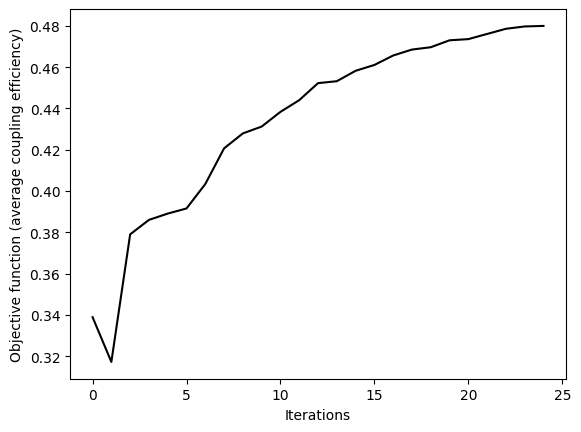

In [19]:
plt.plot(J_history, c="black")
plt.xlabel("Iterations")
plt.ylabel("Objective function (average coupling efficiency)")
plt.show()

### Design the Apodized GC

For comparison with more established methods, we'll simulate a device designed using the approach introduced in the reference [paper](https://doi.org/10.1038/s41598-017-16505-z). First of all, the Bragg condition is given by 

$$
p_{\text{i}} = \frac{\lambda_\text{c}}{(n_{\text{eff,i}} - n_{\text{c}}\sin \theta_{\text{c}})},
$$

where $p_{\text{i}}$ is the local period of the grating, $\lambda_\text{c}$ is the central wavelength, $n_{\text{c}}$ is the refractive index of the cladding, $\theta_{\text{c}}$ is the incident angle in the cladding (~ 10 degrees from Snell's law), and 

$$
n_{\text{eff,i}} = f_\text{i} \times n_\text{neff,nonetch} + (1-f_\text{i}) \times n_\text{neff,etch}.
$$

Here $f_\text{i}$ is the local filling fraction, $n_\text{neff,unetch}$ is the effective index of the slab mode of the unetched waveguide (260 nm thick), and $n_\text{neff,etch}$ is the effective index of the slab mode of the etched waveguide (100 nm thick). $n_\text{neff,unetch}$ and $n_\text{neff,etch}$ are determined to be about 2.9 and 2.2 by mode analysis (not shown). Furthermore, we follow a linear apodization, namely 

$$
f_\text{i} = f_\text{0} - R \times x,
$$

where $f_\text{0}$ is the filling fraction of the first period, $R$ is the linear apodization factor and $x$ is the position of each tooth from the starting point of the grating. By using an initial local filling fraction $f_\text{0}$=0.9 and apodization factor $R$=0.0025 µm$^{-1}$ we can recursively calculate $p_{\text{i}}$ and $f_\text{i}$ for $i=0, 1, ..., N-1$ using the equations above. The result is a grating with apodized pitch length and filling fraction.

For more details on the design principles, refer to the reference [paper](https://doi.org/10.1038/s41598-017-16505-z).

In [20]:
# and then the apodized design parameters to compare to later

R = 0.025  # linear apodization factor

p_list_apodized = []  # list to store all local periodicities
f_list_apodized = []  # list to store all local filling fractions

f0_apodized = 0.86  # filling fraction of the first teeth
f_current = f0_apodized  # variable to store the current local filling fraction

# recursively calculate all local periodicities and filling fractions
for i in range(N):
    p_current = get_periodicity(f_current)
    p_list_apodized.append(p_current)
    f_list_apodized.append(f_current)
    f_current = f0_apodized - R * sum(p_list_apodized)

widths_apodized = get_widths(p_list_apodized, f_list_apodized)
params_apodized = inverse_project(widths_apodized)
sim_apodized = make_2d_sim(params_apodized)

Let's plot all of the simulations together to see how their features compare.

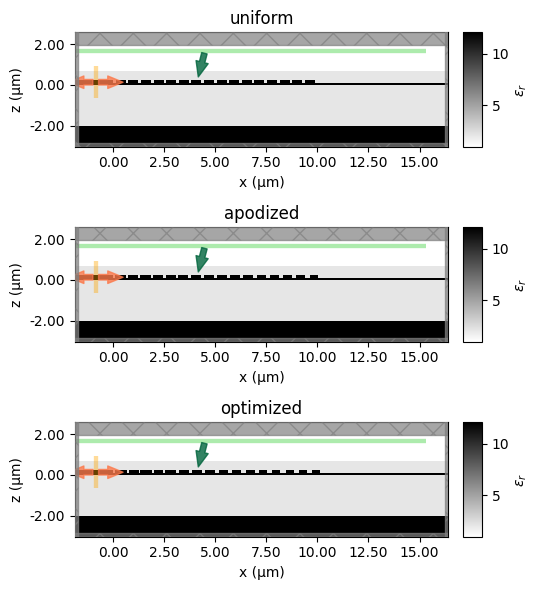

In [21]:
params_opt = params_history[-1]
sim_opt = make_2d_sim(params_opt)

f, (ax1, ax2, ax3) = plt.subplots(3, 1, tight_layout=True, figsize=(10, 6))

sim0.plot_eps(y=0, freq=freq0, ax=ax1)
sim_apodized.plot_eps(y=0, freq=freq0, ax=ax2)
sim_opt.plot_eps(y=0, freq=freq0, ax=ax3)

ax1.set_title("uniform")
ax2.set_title("apodized")
ax3.set_title("optimized")


plt.show()

Next, we'll run each of the designs to be able to compare the coupling efficiencies directly. 

In [22]:
sim_data_apodized = web.run(simulation=sim_apodized, task_name="apodized design")
sim_data_opt = web.run(simulation=sim_opt, task_name="optimized design")

13:31:17 CEST Created task 'apodized design' with task_id                       
              'fdve-434b9d23-92a5-4284-b244-7d41a7fc5bb0' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=125884;https://tidy3d.simulation.cloud/workbench?taskId=fdve-434b9d23-92a5-4284-b244-7d41a7fc5bb0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=300093;https://tidy3d.simulation.cloud/workbench?taskId=fdve-434b9d23-92a5-4284-b244-7d41a7fc5bb0\taskId]8;;\]8;id=125884;https://tidy3d.simulation.cloud/workbench?taskId=fdve-434b9d23-92a5-4284-b244-7d41a7fc5bb0\=]8;;\]8;id=735205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-434b9d23-92a5-4284-b244-7d41a7fc5bb0\fdve]8;;\]8;id=125884;https://tidy3d.simulation.cloud/workbench?taskId=fdve-434b9d23-92a5-4284-b244-7d41a7fc5bb0\-434b9d23-92]8;;\
              ]8;id=125884;https://tidy3d.simulation.cloud/workbench?taskId=fdve-434b9d23-92a5-4284-b244-7d41a7fc5bb0\a5-4284-b244-7d41a7fc5bb0']8;;\.

              Task folder: ]8;id=506873;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:31:19 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:31:20 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:31:27 CEST starting up solver

              running solver

Output()

13:31:32 CEST early shutoff detected at 44%, exiting.

13:31:33 CEST status = postprocess

Output()

              status = success

13:31:35 CEST View simulation result at                                         
              ]8;id=392177;https://tidy3d.simulation.cloud/workbench?taskId=fdve-434b9d23-92a5-4284-b244-7d41a7fc5bb0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=541572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-434b9d23-92a5-4284-b244-7d41a7fc5bb0\taskId]8;;\]8;id=392177;https://tidy3d.simulation.cloud/workbench?taskId=fdve-434b9d23-92a5-4284-b244-7d41a7fc5bb0\=]8;;\]8;id=242839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-434b9d23-92a5-4284-b244-7d41a7fc5bb0\fdve]8;;\]8;id=392177;https://tidy3d.simulation.cloud/workbench?taskId=fdve-434b9d23-92a5-4284-b244-7d41a7fc5bb0\-434b9d23-92]8;;\
              ]8;id=392177;https://tidy3d.simulation.cloud/workbench?taskId=fdve-434b9d23-92a5-4284-b244-7d41a7fc5bb0\a5-4284-b244-7d41a7fc5bb0']8;;\.

Output()

13:31:36 CEST loading simulation from simulation_data.hdf5

13:31:37 CEST Created task 'optimized design' with task_id                      
              'fdve-c5225349-952d-4dcc-84b9-c3ee4bd1f746' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=526877;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c5225349-952d-4dcc-84b9-c3ee4bd1f746\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=616840;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c5225349-952d-4dcc-84b9-c3ee4bd1f746\taskId]8;;\]8;id=526877;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c5225349-952d-4dcc-84b9-c3ee4bd1f746\=]8;;\]8;id=476496;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c5225349-952d-4dcc-84b9-c3ee4bd1f746\fdve]8;;\]8;id=526877;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c5225349-952d-4dcc-84b9-c3ee4bd1f746\-c5225349-95]8;;\
              ]8;id=526877;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c5225349-952d-4dcc-84b9-c3ee4bd1f746\2d-4dcc-84b9-c3ee4bd1f746']8;;\.

              Task folder: ]8;id=115215;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

13:31:39 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:31:40 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:31:47 CEST starting up solver

              running solver

Output()

13:31:51 CEST early shutoff detected at 44%, exiting.

              status = postprocess

Output()

              status = success

13:31:53 CEST View simulation result at                                         
              ]8;id=874034;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c5225349-952d-4dcc-84b9-c3ee4bd1f746\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=732613;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c5225349-952d-4dcc-84b9-c3ee4bd1f746\taskId]8;;\]8;id=874034;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c5225349-952d-4dcc-84b9-c3ee4bd1f746\=]8;;\]8;id=634055;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c5225349-952d-4dcc-84b9-c3ee4bd1f746\fdve]8;;\]8;id=874034;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c5225349-952d-4dcc-84b9-c3ee4bd1f746\-c5225349-95]8;;\
              ]8;id=874034;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c5225349-952d-4dcc-84b9-c3ee4bd1f746\2d-4dcc-84b9-c3ee4bd1f746']8;;\.

Output()

13:31:54 CEST loading simulation from simulation_data.hdf5

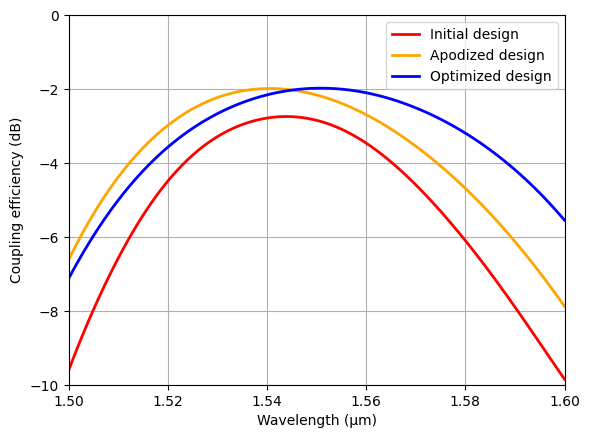

In [23]:
ce_opt = compute_ce(sim_data_opt)
ce_apodized = compute_ce(sim_data_apodized)

plt.plot(ldas, dB(ce0), c="red", linewidth=2, label="Initial design")
plt.plot(ldas, dB(ce_apodized), c="orange", linewidth=2, label="Apodized design")
plt.plot(ldas, dB(ce_opt), c="blue", linewidth=2, label="Optimized design")
plt.xlim(min(ldas), max(ldas))
plt.ylim(-10, 0)
plt.xlabel("Wavelength (µm)")
plt.ylabel("Coupling efficiency (dB)")
plt.legend()
plt.grid()
plt.show()

We see that the optimized and apodized designs both exceed that of the uniform with -2dB efficiency. However, the optimized design far outperforms in terms of bandwidth. We can also confirm that the minimal feature size is maintained above 85 nm.

In [24]:
print("Uniform:")
print(f"  The 1dB bandwidth is {bandwidth(ldas, ce0):.1f} nm")
print(f"  The maximum coupling efficiency is {np.max(dB(ce0)):.2f} dB.")
print(f"  The minimal feature size is {1e3 * np.min(project(params0)):.2f} nm.")
print("")
print("Apodized:")
print(f"  The 1dB bandwidth is {bandwidth(ldas, ce_apodized):.1f} nm")
print(f"  The maximum coupling efficiency is {np.max(dB(ce_apodized)):.2f} dB.")
print(f"  The minimal feature size is {1e3 * np.min(project(params_apodized)):.2f} nm.")
print("")
print("Optimized:")
print(f"  The 1dB bandwidth is {bandwidth(ldas, ce_opt):.1f} nm")
print(f"  The maximum coupling efficiency is {np.max(dB(ce_opt)):.2f} dB.")
print(f"  The minimal feature size is {1e3 * np.min(project(params_opt)):.2f} nm.")

Uniform:
  The 1dB bandwidth is 36.0 nm
  The maximum coupling efficiency is -2.74 dB.
  The minimal feature size is 86.12 nm.

Apodized:
  The 1dB bandwidth is 43.0 nm
  The maximum coupling efficiency is -1.99 dB.
  The minimal feature size is 85.00 nm.

Optimized:
  The 1dB bandwidth is 51.0 nm
  The maximum coupling efficiency is -1.98 dB.
  The minimal feature size is 86.12 nm.


## Take the Model Further


In this notebook, we only perform 2D simulations. A good next step would be to convert the 2D design to a 3D linear GC or focusing GC. The coupling efficiency of the 3D GC is likely slightly lower than that in 2D. Inverse design can then be applied to fine-tune it again. To minimize the footprint, one can potentially also apply shape optimization to design a compact and low-loss taper section, as demonstrated in this [example](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/Autograd5BoundaryGradients.html). 

### Further visualizations

In case you would like to gain more insight into how your device has changed over optimization, the following are a few post-processing steps to make animations and visualize the grating teeth locations.

In [25]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(10, 3))

sim0 = make_2d_sim(params_history[0])


def plot_fn(params, ax=ax):
    sim = make_2d_sim(params)
    ax = sim.plot_eps(y=0.0, ax=ax, freq=freq0)
    ax.set_aspect("equal")


def animate(i):
    plot_fn(params_history[i])


# create animation
ani = animation.FuncAnimation(fig, animate, frames=len(params_history))
plt.close()

In [26]:
td.config.logging_level = "ERROR"

# display the animation (press "play" to start)
HTML(ani.to_jshtml())

<Figure size 640x480 with 0 Axes>

In [27]:
# uncomment to save to file
# ani.save("/users/twhughes/Desktop/apodized_grating_coupler.gif", fps=10)

In [28]:
history_min = [[] for _ in range(len(params_history))]
history_max = [[] for _ in range(len(params_history))]

for i, params in enumerate(params_history):
    sim = make_2d_sim(params)
    for geometry in sim.structures[2].geometry.geometries:
        (xmin, _, _), (xmax, _, _) = geometry.bounds
        history_min[i].append(xmin)
        history_max[i].append(xmax)
        # print(i, j)

history_min = np.array(history_min).T
history_max = np.array(history_max).T

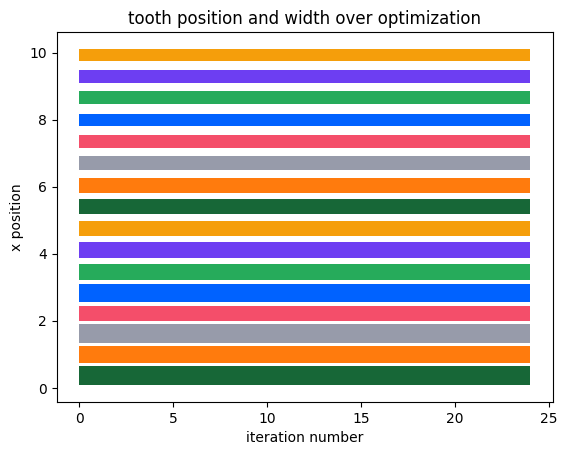

In [29]:
from matplotlib.pyplot import fill_between

xs = np.arange(len(params_history))

_, ax = plt.subplots()

for y1, y2 in zip(history_min, history_max):
    fill_between(xs, y1, y2)

plt.xlabel("iteration number")
plt.ylabel("x position")
plt.title("tooth position and width over optimization")

plt.show()